This notebook implements and **simulates a 1D continuous attractor network** (two-ring architecture) to reproduce the qualitative behavior of **Fig. 4c–4d** in *Neupane, Fiete & Jazayeri (2024)*.

# From LM-GC Plasticity Model to CAN model of Grid cells
The Toy Plasticity Model was an auto-associative $1D$ model whose goal was to:
- Give the system a LM unit that is able to recognize periodicity and phase of landmarks
- Learns and represents the internal landmark phases matching external rhythm
- Generates internal landmark drive even when external signal is not visible

In other words, LM teaches the brain which internal module has the correct frequency and which phase in that model aligns with the external landmark, and after learning, LM can fire at the right times even without sensory landmarks.

### Given that an internal landmark signal exists, how does it shape the dynamics of a CAN and the variability of timing?
What we add here:
- A **Burak & Fiete–style CAN** (ring attractor) that supports **velocity-driven bump motion** (path integration).
- A **Neupane et al.–style internal-landmark “reset/correction” input** that can reduce drift/variance.

We'll be explicit about what comes from which model:

- **[BF09-like]**: Mexican-hat recurrent kernel on a ring + asymmetric shifts in the two populations + velocity gain that biases left vs right population.
- **[NFJ24 new]**: internal landmark inputs that are triggered *endogenously* at learned phases, with a temporally-shaped amplitude envelope.

> 
The goal of the CAN model is to show the effects of endogenous landmarks on **path integration** and **timing** and **simulate the post-learning scenario**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from typing import Tuple

## 0. CAN Model - Conceptual description
The CAN model is a **$1D$ continuous attractor network** that:

- forms and maintains a **localized activity bump** on a ring of neurons
- keeps the bump **stable** (preserves shape, only translates it around the ring)
- optionally receives **internal landmark inputs** at specific phases on the ring
- produces bump trajectories and reaction times (time to reach an end phase)

A canonical CAN: (all CANs??? what's the definition?)
- has neurons arranged on a *ring* ($1D$ circular manifold)
- has **translation invariant connectivity** (each neuron excites near neighbors inhibits far ones)
- supports a **stable bump of activity**:
    - a localized hill of firing that can move smoothly along the ring
- bump position $\leftrightarrow$ internal representation of a variable (eg. phase, time, location)

### Bump center (phase)
- we track its center as a scalar index:
    - $\text{nn\_state}[t] \in \{0, \dots, K-1\}$

- the CAN moves this bump smoothly along the ring according to a **noisy velocity input**
- This tracked $\text{nn\_state}$ is the **1D path-integrated variable** used for:
    - stopping the trial when the bump reaches an `end_phase`
    - triggering internal landmark inputs when the bump crosses learned landmark phases


Tracking the position of the bump center (peak) in time is a way to model **path integration**





## 1. Network architecture
We model a single module as an independent ring attractor.

- ### Ring populations
    We simulate **two populations** (Left and Right), representing two directionally biased copies of the same $1D$ module, each with **K neurons** arranged on a ring.

    - $s(t) ∈ R^{2K}$: network state (activity), concatenated as $[s_L(t), s_R(t)]$
    - $s_L(t) ∈ R^{K}$: left ring activity
    - $s_R(t) ∈ R^{K}$: right ring activity
    


- ### Mexican-hat connectivity matrix (Difference of Gaussians)
    We define a 1D lateral connectivity kernel on the ring

    $\text{MexHat}[k] = A_{\text{exc}}\exp(-s_{\text{exc}}z^2_k) - A_{\text{inh}}\exp(-s_{\text{inh}}z^2_k)$

    - $z_k \in \{-\frac{K}{2}, \dots, \frac{K}{2}-1\}$ is the circular distance
    - $A_{\text{exc}}$, $A_{\text{inh}}$ are amplitudes
    - $s_{\text{exc}}$, $s_{\text{inh}}$ are control widths

    This kernel has:
    - local excitation (narrow Gaussian)
    - broader inhibition (larger Gaussian)

    It ensures a **single stable bump** and is built such that **neighbours excite neighbours**:
    - Neurons near bump center must excite each other to maintain bump height
    - Neurons far away must inhibit each other to prevent multiple bumps from appearing

- ### Directionally biased synapses

    We build four $K \times K$ weight matrices such that each row $i$ defines **incoming** weights onto neuron $i$, depending on the interacting type of populations:
    - **2 Directional**: they create a **bump drift** (clockwise for right direction, counterclockwise for left)
        - $W_{RR}$: $R \leftarrow R$, shifted by $-1$
        - $W_{LL}$: $L \leftarrow L$, shifted by $+1$

    - 2 coupling the two populations: enforce a single bump is shared between L and R
        - $W_{RL}$: $R \leftarrow L$
        - $W_{LR}$: $L \leftarrow R$
    
    This makes the model a continuous attractor network with **direction selectivity**
    

**Why this architecture produces a moving bump**:
- According to Burak & Fiete ring attractor
    - Recurrent Mexican-hat connectivity stabilizes a single peak of activity
    - Velocity modulation makes one side stronger $\rightarrow$ bump shifts
    - Low-pass dynamics smooth the motion
    
- NFJ24 becomes:
    - uses two rings (L and R)
    - adds landmark-triggered input
    - tracks where the bump moves


## 2. Parameters

- ### Initialization parameters:

    Initiate class CAN_Network using structural parameters, which follow *Burak & Fiete (2009)*
    - $K$: (364) number of ring neurons in a population

    - Numerics: 
        - $dt$: step size of numerical integration (s)
        - $\tau_s$: synaptic time constant (s)

    - Drive    
        - $\beta_{\text{vel}}$: gain on velocity input (controls how strongly the bump moves per unit velocity)
        - $\beta_0$: global feedforward excitatory drive amplitude (sets how excitable the network is)
    
    - mexhat: built using connectivity shape parameters: 
        - $A_{\text{exc}}$, $A_{\text{inh}}$ 
        - $s_{\text{exc}}$, $s_{\text{inh}}$

- ### Task-specific parameters:
    - baseline speeds used to compute velocity input $v(t)$, which is a noisy velocity input that is computed then kept constant per-trial
        - $\text{wolm\_speed}$: without internal landmarks
        - $\text{wlm\_speed}$: with internal landmarks
    - $\text{wm}$: Weber fraction controlling speed noise

    - $\text{landmark\_input\_loc}$: array of neuron indices indicating the phases at which endogenous landmarks are stored


*RK)* the paper doesn't go parameter-by-parameter with biological justification. They say that the CAN was adapted from *Burak & Fiete* + they did grid searches over velocity to match the behavioral periodicity and ensure robustness across Weber fractions

Eg. $\beta_{\text{vel}}$ was calibrated so that with the chosen speeds $\text{wolm}$ $\text{wlm}$ the model reproduces the $\sim 0.65s$ periodicity and matched mean time to target

# 3. CAN Simulation

It assumes a full CANNetwork with attributes $K$, $dt$, $\tau_s$, $\beta_\text{vel}$, $\beta_0$, $FF_\text{global}$, $W_\text{RR}$, $W_\text{LL}$, $W_\text{RL}$, $W_\text{LR}$.

At time step $t$ we compute:
- One **noisy velocity sample** per trial and keep it constant over time: $v(t)= v_\text{base} + v_\text{noise}$
    - with landmarks $\rightarrow$ $v_\text{base} = \text{wlm\_speed}$
    - without landmarks $\rightarrow$ $v_\text{base} = \text{wolm\_speed}$
- Left ring and right ring activity $s_L$, $s_R$ 
- **Velocity gains**:
    - $v_L = 1 - \beta_{\text{vel}} * v(t)$
    -  $v_L = 1 + \beta_{\text{vel}} * v(t)$
    - modulate how strongly the recurrent input moves the bump left / right
- **Recurrent input** (vectors in $\mathbb{R}^K$)
    - $g_{\text{LR}} = <W_{LR}, s_R>$,   $g_\text{LL} = <W_{LL}, s_L>$
    - $g_{\text{RR}} = <W_{RR}, s_R>$,   $g_\text{RL} = <W_{RL}, s_L>$
    - represent how neurons from either population excite each others (e.g. how R neurons influence L and viceversa for all combinations)
- **Pre-activation currents**
    - $G = [G_L, G_R]$  
    - $G_L$: $v_L \times (g_{LL} + g_{LR} + FF_{\text{global}}) + \text{lm\_input}$,
        - total contribution into the left ring neurons 
    - $G_R$: $v_R \times (g_{RL} + g_{RR} + FF_{\text{global}}) + \text{lm\_input}$,
        - 'into-right direction contribution'
- **Activation / firing rate**  
    - $F = \text{ReLU(G)}$
    - Burak & Fiete use a threshold-linear (ReLU) activation
- **Euler step**
    - $s(t) = s(t-1) + (F - s(t-1)) * dt / \tau_s$
    - synaptic low-pass update


## 4. Algorithms

### 4.1 Initialization [BF09-like + small static bump]
Goal: let the ring settle into a stable bump attractor.

**Algorithm**
1. Create a small noisy velocity input (constant over the init block).
2. Add a weak static Gaussian “seed” input at a chosen ring location (just to pick a phase).
3. Integrate the CAN dynamics for $T_\text{init} = 10$ seconds.
4. Return the final state $s_\text{init} ∈ R^{2K}$, which will be the initial condition for the actual simulation.

    It is a $10s$ dynamics that is not modeling sensory landmarks, but it is stabilizing the network into a proper attractor bump before the task begins.
    - No task stimuli
    - No learned landmarks
    - No external cues
    - Just initialize the bump attractor to a stable state

**Biological interpretation**: In the brain, grid-cell attractor dynamics don’t start from random noise at the beginning of every trial — they are already in a stable state from previous activity. 

The “landmark” here is just a weak Gaussian to ensure the bump starts somewhere predictable.

### 4.2 Trial simulation  [BF09-like + optional NFJ24 landmark resets]
Goal: simulate one timing/path-integration trial.

**Algorithm**
1. Initialize initial network activity $s[:,0] = s_\text{init}$.
2. Draw one noisy scalar velocity $v$ for the whole trial (using Weber noise).
3. For each timestep $t$:
  - compute recurrent inputs and pre-activation currents
  - if internal landmarks are enabled:
    - check which landmark phase has been passed
    - if it is the first entry, store entry time in the 'landmark region'
    - compute a time-envelope amplitude $\text{amp}(\text{dt})$ (Gaussian in time since entry)
    - inject a spatial Gaussian bump centered at that landmark (or slightly shifted)
  - apply ReLU and low-pass update
  - track the bump center via a local-maximum search around the previous center
4. Stop when the bump phase reaches the stopping threshold.

Outputs per trial:
- $\text{nn\_state}(t)$: trajectory
- trial duration / reaction time $\text{RT} = (\#\text{ steps})*dt$
- optional state matrix $s$ for debugging/visualization


- ### During run_trial (CAN model)
    - The subject performs the internal timing task.
    - Landmarks do not correspond to external stimuli (there are no external cues in the reproduction phase)
    - Only internal landmark triggers (if landmarkpresent=True), and they are triggered by the bump reaching certain internal phases.
    - These internal triggers reduce drift variance and explain the periodicity seen in behavior.


In [2]:
mypath = os.path.abspath("..")
print("CWD:", os.getcwd())
sys.path.insert(0, mypath)

CWD: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN


In [3]:
from CAN.CAN_network import CANNetwork
from CAN.CAN_simulator import CANSimulator

We simulate a run mirroring the parameters chosen by the authors:

In [5]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)

We introduce a helper conversion between indices $(0, \dots, K-1)$ and degrees $(0, 360)$

In [6]:
def idx_to_deg(idx, K):
    return (np.asarray(idx) * 360.0) / K

def deg_to_idx(deg, K):
    return (np.asarray(deg) * K) / 360.0


print("Index 0 -> deg:", idx_to_deg(0, K))
print("Deg 180 -> idx:", deg_to_idx(180, K))


Index 0 -> deg: 0.0
Deg 180 -> idx: 182.0


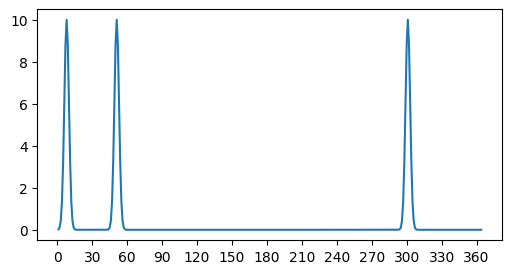

In [10]:
landm_input = sim.generate_landmark_input(
    centers= [7, 50, 300],
    std= 2.0,
    ampl_scaling = 10.0)
plt.figure(figsize = (6,3))
plt.plot(np.arange(1, K+1), landm_input)
plt.xticks(np.arange(0, K, 30))
plt.show()

### Initialization
We run $\text{init\_state}()$ and plot the final activity in both populations.
You should see:
- a localized bump in each ring
- similar shapes, typically with a small constant shift between L and R (expected in this architecture)


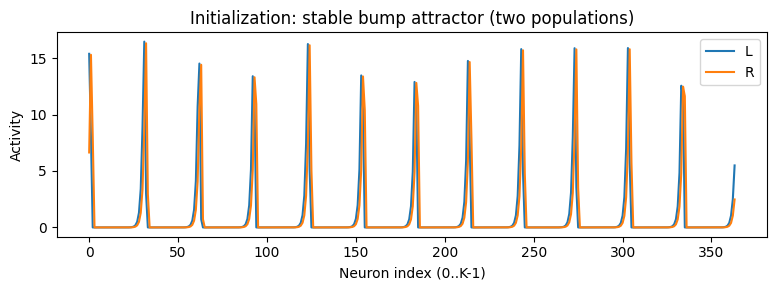

Peak idx L: 31 Peak idx R: 32


In [11]:
init = sim.init_state(T=10.0)

plt.figure(figsize=(8,3))
plt.plot(np.arange(K), init[:K], label="L")
plt.plot(np.arange(K), init[K:], label="R")
plt.title("Initialization: stable bump attractor (two populations)")
plt.xlabel("Neuron index (0..K-1)")
plt.ylabel("Activity")
plt.legend()
plt.tight_layout()
plt.show()

print("Peak idx L:", int(np.argmax(init[:K])), "Peak idx R:", int(np.argmax(init[K:])))


In [12]:
zL = init[:K]
peaks = np.where((zL[1:-1] > zL[:-2]) & (zL[1:-1] > zL[2:]))[0] + 1
print("num local maxima (rough):", len(peaks))
print("top 10 peak idx:", peaks[np.argsort(zL[peaks])][-10:])

num local maxima (rough): 11
top 10 peak idx: [183  92 153  62 213 243 273 303 123  31]


### initial activity created
From the synaptic construction in CANNetwork, which mirrors Burak & Fiete (2009), the Left (L) and Right (R) populations are two copies of the same ring attractor. They are wired with slightly shifted recurrent connectivity in opposite directions.

As a result, their bumps are:
- identical in shape
- stable

but systematically phase-shifted with respect to each other. This allows velocity-driven motion of the bump.

#### Interpretation:
within-population connectivity:
- $L \leftarrow L$ connections are shifted by $+1$
- $R \leftarrow R$ onnections are shifted by $-1$

Cross-population connectivity:
- $L \leftarrow R$ and $R \leftarrow L$ are unshifted

It's like each ring wants to form a stable bump due to the Mexican-hat kernel, but the preferred alignment of that bump depends on how the kernel is shifted. This makes the two population bumps be slightly shifted in opposite directions. The two populations are always active together, and settle into a **consistent phase relationship**

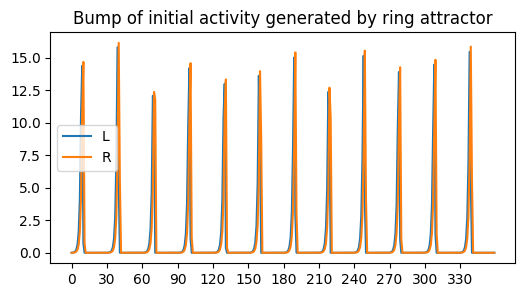

In [16]:
init_activity = model.init_state()
plt.figure(figsize = (6,3))
plt.plot(np.arange(0, K), init_activity[:K], label='L')
plt.plot(np.arange(0, K), init_activity[K:], label='R')
plt.xticks(np.arange(0, K, 30))
plt.title("Bump of initial activity generated by ring attractor")
plt.legend()
plt.show()

Given:
- init_state
- parameters needed to create the landmark bump to inject
- params to initialize per-trial noisy velocity input



**clarifications**:
- the landmark gaussian has an amplitude amp(t) which is a gaussian in time. starts near 0 when we enter the region, grows to a peak and decays again with temporal scale tau
- landmark onset steps: when the bump phase crosses the landmark location, we say we enter the region of landmark. landmarl onset steps is the number of time steps taken after entering this region until reaching the peak in amplitude.

- landmark tau steps: the number of time steps taken for the amplitude to decay from the peak.\
    this means that internal landmarks are not an instantaneous kick, but a temporally extended boost around each learned phase.

    - if one unit step takes dt = 1/10 s -> landmark onset steps=500 means that 500 steps are required to reach the peak-> in seconds, 500*dt = 50


in each time step
- current velocity -> pick one noisy velocity per trial and keep it constant (using fine-tuned params by Neup&al)
- CAN dynamics: get current state and let the network evolve until phase threshold or time limit
- compute velocity biases
- compute recurrent synaptic inputs (recurrent contributions from the ring attractor)

- if we are at / near a landmark:
    - copute a landmark input bump and add it to both populations
- appply relu and update activity (euler step)
- stop when bump phase passes end_phase or when we hit time limit



tracking:
- nn_state: 1d list of bump center positions, written in terms of indices of ring neurons
- landmark bookkeeping:
    - lm_locs: ring neuron indices (phases) where learned landmarks live (list)
    - lm_flag: tells at which lm (lm k) we are in now (0 means none seen yet)
    - lm_times[k]: the time step when we first entered landmark region for landmark k

In [86]:
lm_locs = np.array([3.0, 7.0, 10.0])
phase = 2.0

last_lm_locs = [loc for loc in lm_locs if loc <= phase]
if last_lm_locs:
    last_lm_loc = last_lm_locs[-1]
    last_lm_idx = len(last_lm_locs)
else:
    last_lm_loc = None
    last_lm_idx = None


In [87]:
last_lm_locs, last_lm_idx

([], None)

In [67]:
K=10
ring = np.arange(0,10)
bump = np.array([3,7,6,3,4,3,4,5,6,3])
last_idx = 8
window = np.arange(last_idx-3, last_idx+4)
window_mod = window % K
bump_window = bump[window_mod]
idx_max_window = np.argmax(bump_window)
idx_max_ring = (last_idx-3+idx_max_window)%K

print(f'ring: {ring}')
print(f'bump: {bump}\n')
print(f'last_idx: {last_idx}, bump value: {bump[last_idx]}')
print(f'window: {window}')
print(f'window_mod: {window_mod}')
print(f'bump_window: {bump_window}')
print(f'idx_max_window: {idx_max_window}')
print(f'idx_max_ring: {idx_max_ring}')


ring: [0 1 2 3 4 5 6 7 8 9]
bump: [3 7 6 3 4 3 4 5 6 3]

last_idx: 8, bump value: 6
window: [ 5  6  7  8  9 10 11]
window_mod: [5 6 7 8 9 0 1]
bump_window: [3 4 5 6 3 3 7]
idx_max_window: 6
idx_max_ring: 1


In [49]:
len(bump)

9